In [1]:
import sys
print(sys.executable)

/usr/bin/python3


In [13]:
import os
import sys
if os.getcwd().endswith('visualize'):
    os.chdir('..')
sys.path.append(os.getcwd())
from loader.dataloader import VideoDataSet,VideoDataLoader
import torch

dataset ="50salads"
split = "train.split1.bundle"
default_path="./data/data/"
knows = 11
unknowns = 8
prototypes = 30
video_dataset = VideoDataSet(dataset=dataset,
                               split=split,
                               default_path=default_path,
                               knowns=knows,
                               unknowns=unknowns,
                               total_classes=knows + prototypes)
data_loader = VideoDataLoader(video_dataset, batch_size=1, shuffle=True)

In [22]:
for batch in data_loader:
    features = batch["features"]
    unknown_mask = batch["unknown_mask"]
    target_truth = batch["target_truth"]
    padding_mask = batch["padding_mask"]
    labels_dict = batch["labels_dict"]
    print(list(labels_dict.keys()))
    
    break

['cut_tomato', 'place_tomato_into_bowl', 'cut_cheese', 'place_cheese_into_bowl', 'cut_lettuce', 'place_lettuce_into_bowl', 'add_salt', 'add_vinegar', 'add_oil', 'add_pepper', 'mix_dressing', 'peel_cucumber', 'cut_cucumber', 'place_cucumber_into_bowl', 'add_dressing', 'mix_ingredients', 'serve_salad_onto_plate', 'action_start', 'action_end', 'UNK']


/tmp/ipykernel_483787/134012851.py:54: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


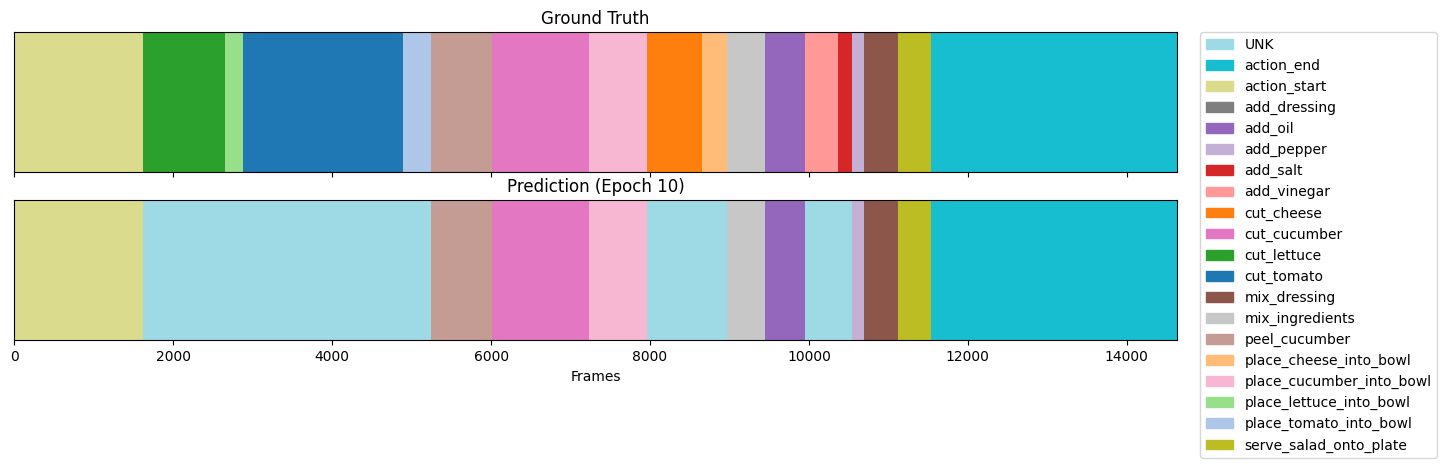

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch
target_truth = target_truth[padding_mask]
unkowns_classes = target_truth.clone().detach()
unkowns_classes[unknown_mask] = 19
plots_data = [
    ("Ground Truth", target_truth),      
    ("Prediction (Epoch 10)", unkowns_classes),
]

num_plots = len(plots_data)
fig, axs = plt.subplots(nrows=num_plots, ncols=1, figsize=(15, 2 * num_plots), sharex=True)

if num_plots == 1:
    axs = [axs]

cmap = plt.get_cmap('tab20')
TOTAL_CLASSES = len(labels_dict)

for i, (title, tensor_data) in enumerate(plots_data):
    if isinstance(tensor_data, torch.Tensor):
        data_np = tensor_data.cpu().numpy()
    else:
        data_np = tensor_data
        
    if data_np.ndim == 1:
        data_np = data_np.reshape(1, -1)
    
   
    axs[i].imshow(data_np, aspect='auto', cmap=cmap, interpolation='nearest', 
                  vmin=0, vmax=TOTAL_CLASSES-1)
    
    axs[i].set_title(title)
    axs[i].set_yticks([]) 
    

    if i == num_plots - 1:
        axs[i].set_xlabel("Frames")

patches = []
sorted_keys = sorted(labels_dict.keys())

for key in sorted_keys:
    color = cmap(labels_dict[key] / (TOTAL_CLASSES - 1))
    
    label_name = f"{key}"
    patch = mpatches.Patch(color=color, label=label_name)
    patches.append(patch)

axs[0].legend(handles=patches, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

(1, 11146)


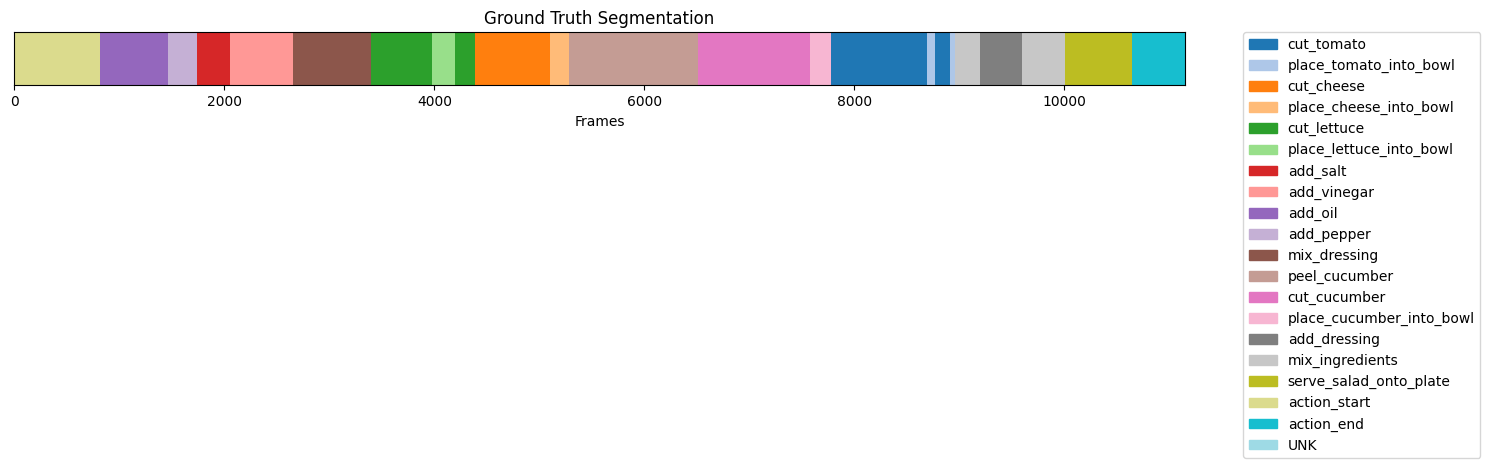

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

labels_np = target_truth.numpy()  

unique_classes = np.unique(list(labels_dict.keys()))

cmap = plt.get_cmap('tab20')

plt.figure(figsize=(15, 3))
print(labels_np.shape)

plt.imshow(labels_np, aspect='auto', cmap=cmap, interpolation='nearest', vmin=0, vmax=19) # vmax anpassen an 
plt.xlabel("Frames")
plt.yticks([])
plt.title("Ground Truth Segmentation")

patches = []
for key in labels_dict.keys():
    color = cmap(labels_dict[key] / 19.0) 
    
    label_name = f"{key}" 
    
    patch = mpatches.Patch(color=color, label=label_name)
    patches.append(patch)

plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()